## Dependencies

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import json
import mediapipe as mp
from skimage.exposure import match_histograms
import torch
from torchvision import models, transforms
from PIL import Image

## Functions

In [41]:


model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()

transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

def DeepLabV3_ind(input_image):
    
    input_tensor = transform(input_image).unsqueeze(0)  # Add batch dimension
    
    with torch.no_grad():
        output = model(input_tensor)
    
    output_predictions = output['out'][0]  
    output_predictions = output_predictions.argmax(0)  
    
    
    PERSON_CLASS = 15  # Class index for "person" in COCO dataset

    
    mask = output_predictions == PERSON_CLASS
    masked_image = np.array(input_image)  # Convert image to NumPy array
    
    
    masked_image[~mask.numpy()] = [255, 255, 255]  # Replace non-person areas with white

    
    # masked_image_pil = Image.fromarray(masked_image)
    
    return masked_image


    colors = ['red', 'green', 'blue']
    channel_names = ['Red', 'Green', 'Blue']

    plt.figure(figsize=(10, 4))

    for i, color in enumerate(colors):
        plt.hist(rgb_image[:, :, i].ravel(), bins=256, range=[0, 256], 
                 color=color, alpha=0.6, label=f'{channel_names[i]} Channel')

    plt.title(f"{title_prefix} RGB Channel Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
def apply_clahe_to_rgb(rgb_image, clip_limit=2.0, tile_grid_size=(8, 8)):
    bgr = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
    
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    v_clahe = clahe.apply(v)
    
    hsv_clahe = cv2.merge((h, s, v_clahe))
    bgr_clahe = cv2.cvtColor(hsv_clahe, cv2.COLOR_HSV2BGR)
    
    rgb_clahe = cv2.cvtColor(bgr_clahe, cv2.COLOR_BGR2RGB)
    return rgb_clahe
def compare_rgb_histograms(img_before, img_after, title_prefix=""):
   
    channel_names = ['Red', 'Green', 'Blue']
    colors = ['red', 'green', 'blue']

    plt.figure(figsize=(15, 4))

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.hist(img_before[:, :, i].ravel(), bins=256, range=[0, 246], 
                 color="red", alpha=0.5, label='Before')
        plt.hist(img_after[:, :, i].ravel(), bins=256, range=[0, 246], 
                 color='green', alpha=0.7, label='After')
        plt.title(f'{title_prefix} {channel_names[i]} Channel')
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
def apply_threshold_mask(image, threshold, operator, channel=None):
    # Select the appropriate channel or all channels
    if channel is not None:
        selected = image[:, :, channel]
    else:
        selected = image.mean(axis=2).astype(np.uint8)

    # Create mask based on operator
    if operator == '<':
        mask = selected < threshold
    elif operator == '>':
        mask = selected > threshold
    elif operator == 'between':
        if not isinstance(threshold, (list, tuple)) or len(threshold) != 2:
            raise ValueError("Threshold must be a tuple (min, max) when operator is 'between'")
        min_t, max_t = threshold
        mask = (selected > min_t) & (selected < max_t)
    else:
        raise ValueError("Operator must be '<', '>', or 'between'")

    # Create yellow overlay
    yellow_mask = np.zeros_like(image, dtype=np.uint8)
    yellow_mask[:, :] = [255, 255, 0]  # RGB yellow

    # Apply mask with transparency
    output = image.copy()
    alpha = 0.5
    output[mask] = cv2.addWeighted(image[mask], 1 - alpha, yellow_mask[mask], alpha, 0)

    # Display result
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    title_str = f"Mask on channel {channel if channel is not None else 'All'} {operator} {threshold}"
    plt.title(title_str)
    plt.axis('off')
    plt.show()

#____________________________________________________________-__________

def DeepLabV3(image_batch, model, transform, device='mps'):
    processed_images = []

    model.to(device)
    model.eval()

    # Preprocess images and move to device
    input_tensors = torch.stack([transform(img) for img in image_batch]).to(device)

    with torch.no_grad():
        
        outputs = model(input_tensors)['out']  # Shape: (B, C, H, W)
        

    PERSON_CLASS = 15  # Person class index in COCO dataset

    for idx, output in enumerate(outputs):
        prediction = output.argmax(0)  # (H, W) tensor
        mask = prediction == PERSON_CLASS

        orig_np = np.array(image_batch[idx]).astype(np.float32)
        mask_resized = cv2.resize(mask.cpu().numpy().astype(np.uint8), (orig_np.shape[1], orig_np.shape[0]))

        dimmed = orig_np * 0.4  
        dimmed[mask_resized == 1] = orig_np[mask_resized == 1]

        processed = np.clip(dimmed, 0, 255).astype(np.uint8)

        processed_images.append(processed)

    return processed_images

def imageProcess(
    rgb_image,
    reference_rgb=None,     
    clahe_clip=2.0,
    clahe_tile_grid=(8, 8),
    gamma=1.0
):  
    
    rgb_image = np.array(rgb_image, dtype=np.uint8)
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=clahe_tile_grid)
    v = clahe.apply(v)

    if reference_rgb is not None:
        ref_hsv = cv2.cvtColor(reference_rgb, cv2.COLOR_RGB2HSV)
        v_ref = ref_hsv[..., 2]
        v = match_histograms(v, v_ref, channel_axis=None).astype(np.uint8)

    v = np.clip(255 * ((v / 255.0) ** (1.0 / gamma)), 0, 255).astype(np.uint8)

    hsv_enhanced = cv2.merge([h, s, v])
    rgb_enhanced = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2RGB)

    return Image.fromarray(rgb_enhanced)

## Load

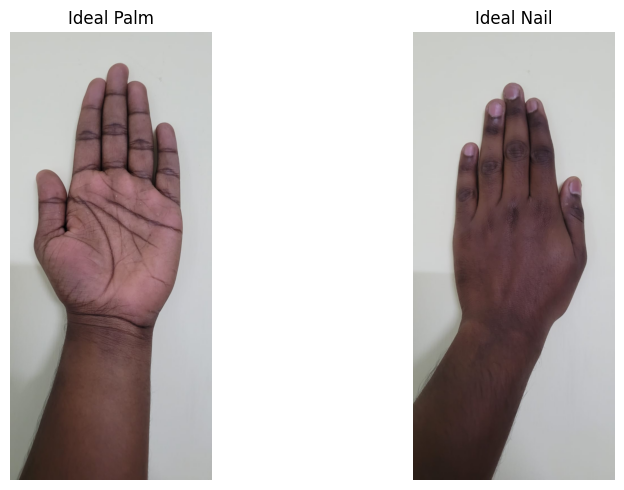

In [15]:
idi = 'ideal'
palm_path = f"/Users/maheshsaravanan/Documents/HemoScan/Dataset/{idi}/PF.jpg"
nail_path =  f"/Users/maheshsaravanan/Documents/HemoScan/Dataset/{idi}/Pb.jpg"
ideal_palm = cv2.imread(palm_path)
ideal_nail = cv2.imread(nail_path)

ideal_palm = cv2.cvtColor(ideal_palm, cv2.COLOR_BGR2RGB)
ideal_nail = cv2.cvtColor(ideal_nail, cv2.COLOR_BGR2RGB)
# ideal_palm = cv2.resize(ideal_palm, (256, 256))
# ideal_nail = cv2.resize(ideal_nail, (256, 256))
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

axes[0].imshow(ideal_palm)
axes[0].set_title("Ideal Palm")
axes[0].axis('off')  # Turn off axis
axes[1].imshow(ideal_nail)
axes[1].set_title("Ideal Nail")
axes[1].axis('off')  # Turn off axis
plt.tight_layout()
plt.show()


# Histogam

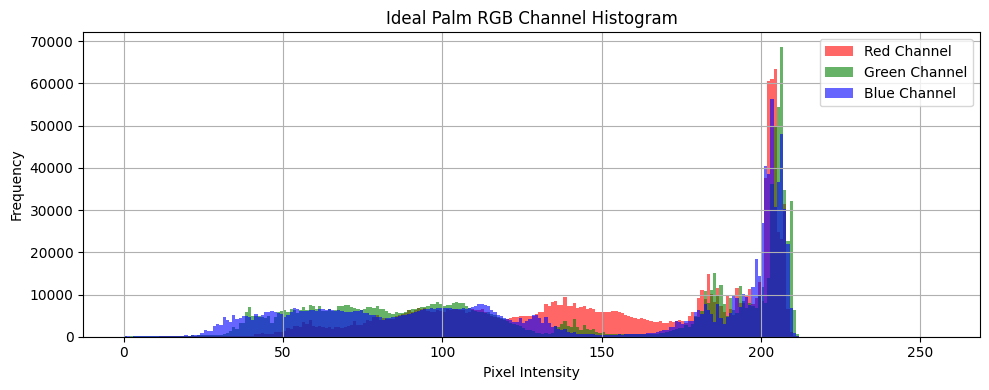

In [28]:
plot_rgb_histogram(ideal_palm, title_prefix="Ideal Palm")



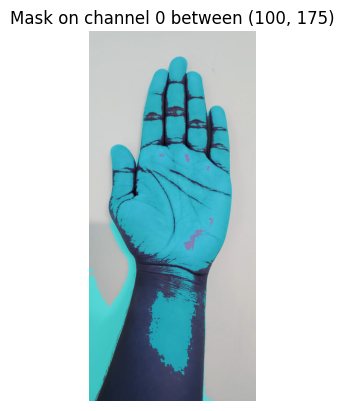

In [25]:
apply_threshold_mask(ideal_palm, (100,175), 'between', channel=0)

# BG Removal

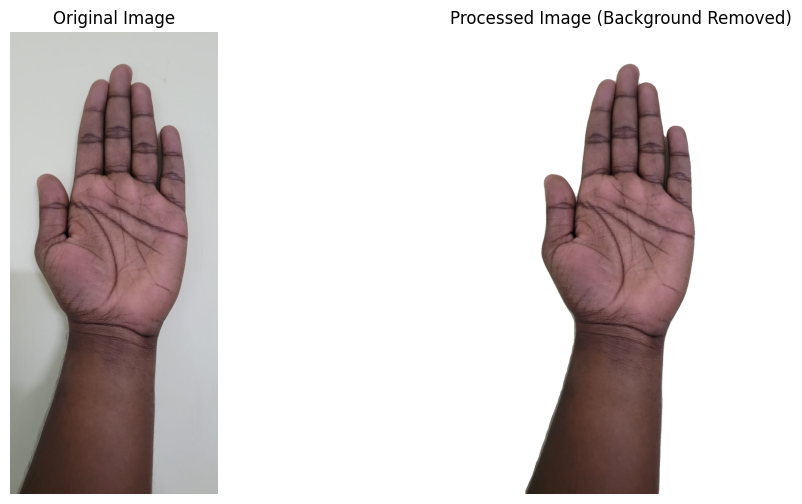

(-0.5, 719.5, 1599.5, -0.5)

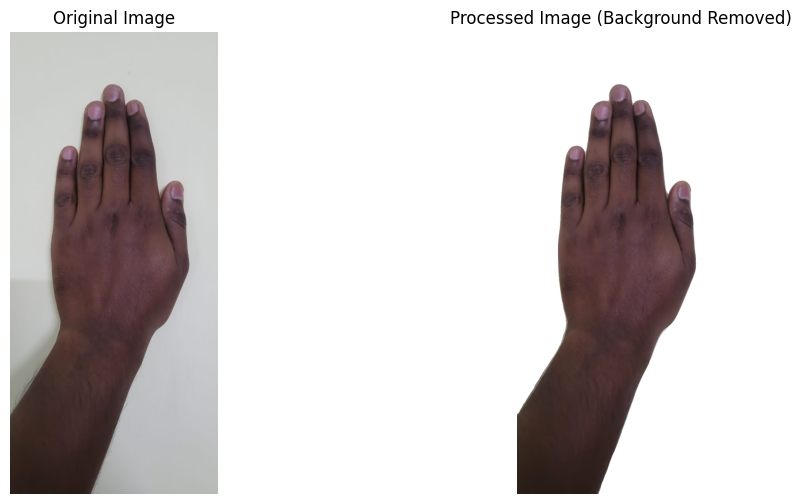

In [10]:

input_image = ideal_palm.copy()

# Process the image and remove the background
# output_image = DeepLabV3(input_image)
ideal_palm = DeepLabV3(input_image)

# Display the original and processed images

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(input_image)
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(ideal_palm)
ax[1].set_title("Processed Image (Background Removed)")
ax[1].axis('off')

plt.show()

input_image = ideal_nail.copy()

# Process the image and remove the background
ideal_nail = DeepLabV3(input_image)

# Display the original and processed images

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(input_image)
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(ideal_nail)
ax[1].set_title("Processed Image (Background Removed)")
ax[1].axis('off')

In [ ]:
base_path = "/Users/maheshsaravanan/Documents/HemoScan/Dataset"

for index in range(1,462,1):

    print(f"{index}/462",end = "")
    palm_path = os.path.join(base_path,f"{index:04d}" , "PF.jpg")
    nail_path = os.path.join(base_path,f"{index:04d}" , "PB.jpg")
    palm = cv2.imread(palm_path)
    nail = cv2.imread(nail_path)


    palm = cv2.cvtColor(palm, cv2.COLOR_BGR2RGB)
    nail = cv2.cvtColor(nail, cv2.COLOR_BGR2RGB)

    pro_palm = DeepLabV3(palm)
    pro_nail = DeepLabV3(nail)
    pro_palm = cv2.cvtColor(pro_palm, cv2.COLOR_RGB2BGR)
    pro_nail = cv2.cvtColor(pro_nail, cv2.COLOR_RGB2BGR)

    cv2.imwrite (os.path.join(base_path,f"{index:04d}" , "PF_background_removed.jpg"),pro_palm)
    cv2.imwrite (os.path.join(base_path,f"{index:04d}" , "PB_background_removed.jpg"),pro_nail)


    
    

# CLACHE

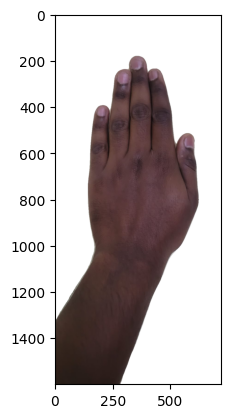

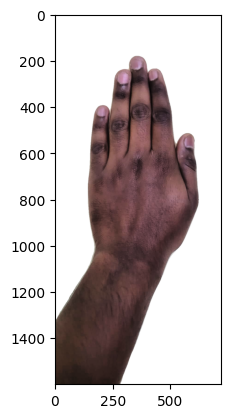

In [11]:
plt.imshow(ideal_nail)
plt.show()
clache_applied= apply_clahe_to_rgb(ideal_nail, clip_limit=2.0, tile_grid_size=(8, 8))
plt.imshow(clache_applied)
plt.show()

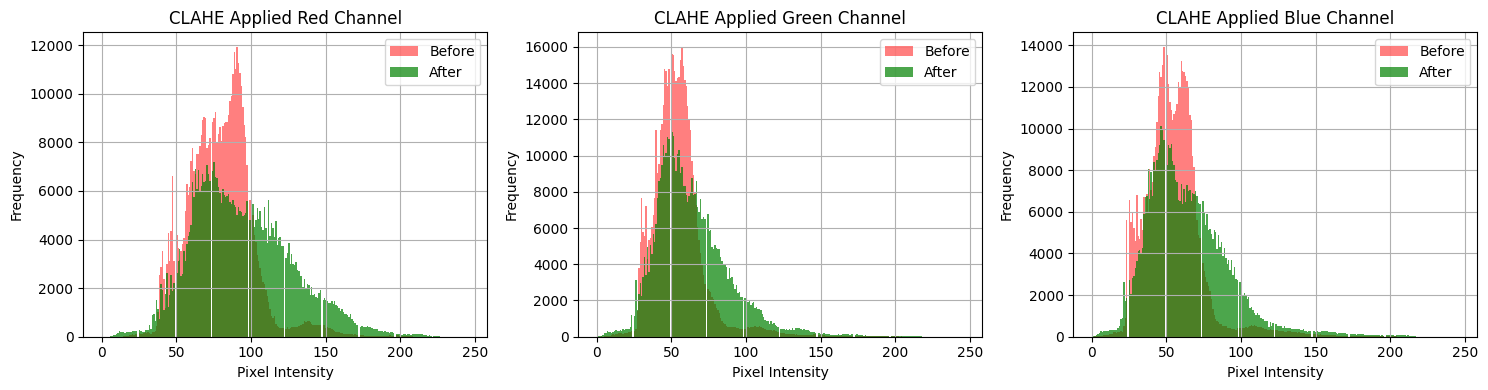

In [15]:
compare_rgb_histograms(ideal_nail, clache_applied, title_prefix="CLAHE Applied")

# Final

In [44]:
palm_images = [
    Image.fromarray(cv2.cvtColor(
        cv2.imread(f"/Users/maheshsaravanan/Documents/HemoScan/Dataset/{idi:04d}/PF.jpg"),
        cv2.COLOR_BGR2RGB
    )) for idi in range(1, 5)
]
palm_images = [Image.fromarray(ideal_palm)]+palm_images

palm_images_processed = [imageProcess(image) for image in palm_images]

processed_batch = DeepLabV3(palm_images_processed, model, transform, device='mps')

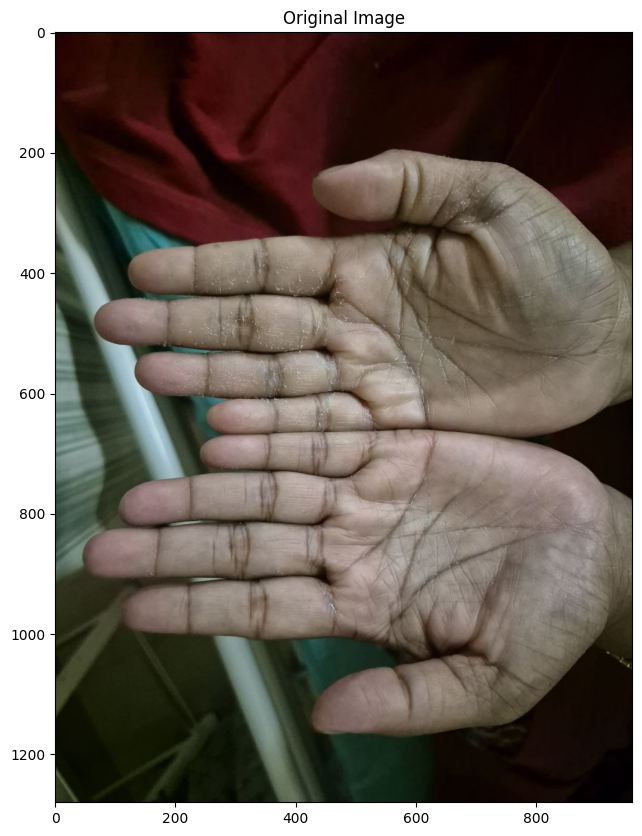

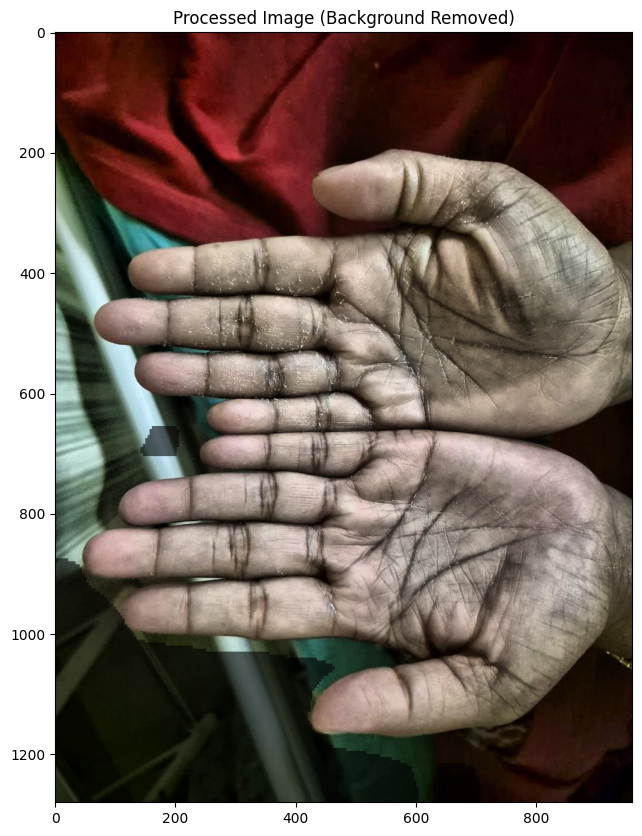

In [46]:
i = 4
plt.figure(figsize=(15, 10))
plt.imshow(palm_images[i])
plt.title("Original Image")
plt.show()
plt.figure(figsize=(15, 10))
plt.imshow(processed_batch[i])
plt.title("Processed Image (Background Removed)")

plt.show()